# Returns comparison

#### Juan Camilo Henao Londono - 22.01.2020
#### AG Guhr - Universität Duisburg-Essen

With this notebook I want to check the difference in the results comparing the midpoint log-returns named but not used in the implementation of
the [paper](https://link.springer.com/content/pdf/10.1140/epjb/e2016-60818-y.pdf)

$$r_i \left( t, \tau \right) = \ln \left( \frac{m_i \left( t + \tau \right)}{m_i \left( t \right)} \right)$$

with the actual used returns in the implementation of the paper

$$r_i \left( t, \tau \right) = \frac{m_i \left( t + \tau \right) - m_i \left( t \right)}{m_i \left( t \right)}$$

In [1]:
# Modules

from itertools import product as iprod
from matplotlib import pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle

__tau__ = 1000

## Log-returns implementation

In [2]:
def taq_bussiness_days(year):
    """Generates a list with the dates of the bussiness days in a year

    :param year: string of the year to be analized (i.e '2008').
    :return: list.
    """

    init_date = f'01/01/{year}'
    last_date = f'12/31/{year}'

    # Use only the bussiness days
    dt = pd.date_range(start=init_date, end=last_date, freq='B')
    dt_df = dt.to_frame(index=False)
    date_list = dt_df[0].astype(str).tolist()

    return date_list

In [3]:
def taq_self_response_day_responses_physical_data(ticker, date):
    """Computes the self-response of a day.

    Using the midpoint price and trade signs of a ticker computes the self-
    response during different time lags (:math:`\tau`) for a day.

    :param ticker: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL').
    :param date: string with the date of the data to be extracted
     (i.e. '2008-01-02').
    :return: tuple -- The function returns a tuple with numpy arrays.
    """

    date_sep = date.split('-')

    year = date_sep[0]
    month = date_sep[1]
    day = date_sep[2]

    try:
        # Load data
        midpoint = pickle.load(open(
                f'../../../taq_data/responses_physical_data_{year}/taq_midpoint'
                + f'_physical_data/taq_midpoint_physical_data_midpoint'
                + f'_{year}{month}{day}_{ticker}.pickle', 'rb'))
        _, _, trade_sign = pickle.load(open(
                f'../../../taq_data/responses_physical_data_{year}/taq_trade_signs'
                + f'_physical_data/taq_trade_signs_physical_data'
                + f'_{year}{month}{day}_{ticker}.pickle', 'rb'))

        assert len(midpoint) == len(trade_sign)

        # Array of the average of each tau. 10^3 s is used in the paper
        self_response_tau = np.zeros(__tau__)
        num = np.zeros(__tau__)

        # Calculating the midpoint price return and the self response function

        # Depending on the tau value
        for tau_idx in range(__tau__):

            trade_sign_tau = trade_sign[:-tau_idx - 1]
            trade_sign_no_0_len = len(trade_sign_tau[trade_sign_tau != 0])
            num[tau_idx] = trade_sign_no_0_len
            # Obtain the midpoint price return. Displace the numerator tau
            # values to the right and compute the return

            # Midpoint price returns
            log_return_sec = np.log(midpoint[tau_idx + 1:] 
                                    / midpoint[:-tau_idx - 1])

            # Obtain the self response value
            if (trade_sign_no_0_len != 0):
                product = log_return_sec * trade_sign_tau
                self_response_tau[tau_idx] = np.sum(product)

        return (self_response_tau, num)

    except FileNotFoundError as e:
        print('No data')
        print(e)
        print()
        zeros = np.zeros(__tau__)
        return (zeros, zeros)

In [4]:
def taq_self_response_year_responses_physical_data(ticker, year):
    """Computes the self-response of a year.

    Using the taq_self_response_day_responses_physical_data function computes the
    self-response function for a year.

    :param ticker: string of the abbreviation of stock to be analized
     (i.e. 'AAPL').
    :param year: string of the year to be analized (i.e '2016').
    :return: tuple -- The function returns a tuple with numpy arrays.
    """

    dates = taq_bussiness_days(year)

    self_values = []
    args_prod = iprod([ticker], dates)

    # Parallel computation of the self-responses. Every result is appended to
    # a list
    with mp.Pool(processes=mp.cpu_count()) as pool:
        self_values.append(pool.starmap(
            taq_self_response_day_responses_physical_data, args_prod))

    # To obtain the total self-response, I sum over all the self-response
    # values and all the amount of trades (averaging values)
    self_v_final = np.sum(self_values[0], axis=0)

    self_response_val = self_v_final[0] / self_v_final[1]
    self_response_avg = self_v_final[1]

    return (self_response_val, self_response_avg)

In [5]:
def taq_cross_response_day_responses_physical_data(ticker_i, ticker_j, date):
    """Computes the cross-response of a day.

    Using the midpoint price of ticker i and trade signs of ticker j computes
    the cross-response during different time lags (:math:`\tau`) for a day.

    :param ticker_i: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL').
    :param ticker_j: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL').
    :param date: string with the date of the data to be extracted
     (i.e. '2008-01-02').
    :return: tuple -- The function returns a tuple with numpy arrays.
    """

    date_sep = date.split('-')

    year = date_sep[0]
    month = date_sep[1]
    day = date_sep[2]

    if (ticker_i == ticker_j):

        # Self-response
        return None

    else:
        try:
            # Load data
            midpoint_i = pickle.load(open(
                    f'../../../taq_data/responses_physical_data_{year}/taq_midpoint'
                    + f'_physical_data/taq_midpoint_physical_data_midpoint'
                    + f'_{year}{month}{day}_{ticker_i}.pickle', 'rb'))
            _, _, trade_sign_j = pickle.load(open(
                    f'../../../taq_data/responses_physical_data_{year}/taq_trade_'
                    + f'signs_physical_data/taq_trade_signs_physical_data'
                    + f'_{year}{month}{day}_{ticker_j}.pickle', 'rb'))

            assert len(midpoint_i) == len(trade_sign_j)

            # Array of the average of each tau. 10^3 s is used in the paper
            cross_response_tau = np.zeros(__tau__)
            num = np.zeros(__tau__)

            # Calculating the midpoint return and the cross response function

            # Depending on the tau value
            for tau_idx in range(__tau__):

                trade_sign_tau = 1 * trade_sign_j[:-tau_idx - 1]
                trade_sign_no_0_len = len(trade_sign_tau[trade_sign_tau != 0])
                num[tau_idx] = trade_sign_no_0_len
                # Obtain the midpoint price return. Displace the numerator tau
                # values to the right and compute the return

                # Midpoint price returns
                log_return_i_sec = np.log(midpoint_i[tau_idx + 1:]
                                          / midpoint_i[:-tau_idx - 1])

                # Obtain the cross response value
                if (trade_sign_no_0_len != 0):
                    product = log_return_i_sec * trade_sign_tau
                    cross_response_tau[tau_idx] = np.sum(product)

            return (cross_response_tau, num)

        except FileNotFoundError as e:
            print('No data')
            print(e)
            print()
            zeros = np.zeros(__tau__)
            return (zeros, zeros)

In [6]:
def taq_cross_response_year_responses_physical_data(ticker_i, ticker_j, year):
    """Computes the cross-response of a year.

    Using the taq_cross_response_day_responses_physical_data function computes
    the cross-response function for a year.

    :param ticker_i: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL').
    :param ticker_j: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL').
    :param year: string of the year to be analized (i.e '2016').
    :return: tuple -- The function returns a tuple with numpy arrays.
    """

    if (ticker_i == ticker_j):

        # Self-response
        return None

    else:
        
        dates = taq_bussiness_days(year)

        cross_values = []
        args_prod = iprod([ticker_i], [ticker_j], dates)

        # Parallel computation of the cross-responses. Every result is appended
        # to a list
        with mp.Pool(processes=mp.cpu_count()) as pool:
            cross_values.append(pool.starmap(
                taq_cross_response_day_responses_physical_data, args_prod))

        # To obtain the total cross-response, I sum over all the cross-response
        # values and all the amount of trades (averaging values)
        cross_v_final = np.sum(cross_values[0], axis=0)

        cross_response_val = cross_v_final[0] / cross_v_final[1]
        cross_response_avg = cross_v_final[1]

        return (cross_response_val, cross_response_avg)

# Comparison

In [7]:
def taq_self_response_returns_comparison(ticker, year):
    """Compares self-response function values.
    
    Compares the results of the self-response function from the TAQ data
    obtained by the `paper
    <https://link.springer.com/content/pdf/10.1140/epjb/e2016-60818-y.pdf>`
    using returns and log-returns.
    
    :param ticker: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL')
    :param date: string of the date to be analized (i.e '2008-07-07')
    :return: None -- The function analyze the data and does not return a
     value.
    """
        
    # Load    
    self_log, _ = taq_self_response_year_responses_physical_data(ticker, year)
    self_ret = pickle.load(open(
                    f'../../../taq_data/responses_physical_data_{year}/taq_self'
                    + f'_response_year_responses_physical_data/taq_self_response'
                    + f'_year_responses_physical_data_{year}_{ticker}.pickle',
                    'rb'))
    
    assert len(self_log) == len(self_ret)
        
    # Comparison
    self_comp = np.mean(np.abs(self_ret - self_log) / self_ret)
    
    print(f'Self-response results - {ticker}')
    print('============================')
    print()
    print('Comparison in the physical time scale')
    print('-----------------------------------')
    print('The relative error in the self-response values is '
          + f'{self_comp * 100:.2f}%')
    print()
    
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    plt.semilogx(self_log, linewidth=5, label=f'Log-returns - {ticker}')
    plt.semilogx(self_ret, linewidth=5, label=f'Returns - {ticker}')
    plt.legend(loc='best', fontsize=25)
    plt.title('Self-responses', fontsize=40)
    plt.xlabel(r'$\tau \, [s]$', fontsize=35)
    plt.ylabel(r'$R_{ii}(\tau)$', fontsize=35)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(1,1000)
    # plt.ylim(13 * 10 ** -5, 16 * 10 ** -5)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.offsetText.set_fontsize(25)
    plt.grid(True)
    plt.tight_layout()
    
    return None

In [8]:
def taq_cross_response_returns_comparison(ticker_i, ticker_j, year):
    """Compares cross-response function values.
    
    Compares the results of the cross-response function from the TAQ data
    obtained by the `paper
    <https://link.springer.com/content/pdf/10.1140/epjb/e2016-60818-y.pdf>`
    using returns and log-returns.
    
    :param ticker_i: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL')
    :param ticker_j: string of the abbreviation of the stock to be analized
     (i.e. 'AAPL')
    :param date: string of the date to be analized (i.e '2008-07-07')
    :return: None -- The function analyze the data and does not return a
     value.
    """
    
    # Load
    cross_log, _ = taq_cross_response_year_responses_physical_data(ticker_i,
                                                                   ticker_j,
                                                                   year)
    cross_ret = pickle.load(open(
                    f'../../../taq_data/responses_physical_data_{year}/taq_cross'
                    + f'_response_year_responses_physical_data/taq_cross_response'
                    + f'_year_responses_physical_data_{year}_{ticker_i}i'
                    + f'_{ticker_j}j.pickle','rb'))

    assert len(cross_log) == len(cross_ret)

    # Comparison
    cross_comp = np.mean(np.abs(cross_ret - cross_log) / cross_ret)

    print(f'Cross-response results - {ticker_i}-{ticker_j}')
    print('==================================')
    print()
    print('Comparison in the physical time scale')
    print('-----------------------------------')
    print('The relative error in the cross-response values is '
          + f'{cross_comp * 100:.2f}%')
    print()
    
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    plt.semilogx(cross_log, linewidth=5, label=f'Log-returns - {ticker_i}-{ticker_j}')
    plt.semilogx(cross_ret, linewidth=5, label=f'Returns - {ticker_i}-{ticker_j}')
    plt.legend(loc='best', fontsize=25)
    plt.title('Cross-responses - article reproduction', fontsize=40)
    plt.xlabel(r'$\tau \, [s]$', fontsize=35)
    plt.ylabel(r'$R_{ij}(\tau)$', fontsize=35)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(1,1000)
    # plt.ylim(4 * 10 ** -5, 9 * 10 ** -5)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.offsetText.set_fontsize(25)
    plt.grid(True)
    plt.tight_layout()
    
    return None

++++++++++++++++++++++++++
Results Returns comparison
++++++++++++++++++++++++++

No data
[Errno 2] No such file or directory: '../../../taq_data/responses_physical_data_2008/taq_midpoint_physical_data/taq_midpoint_physical_data_midpoint_20080101_AAPL.pickle'

No data
[Errno 2] No such file or directory: '../../../taq_data/responses_physical_data_2008/taq_midpoint_physical_data/taq_midpoint_physical_data_midpoint_20080321_AAPL.pickle'

No data
[Errno 2] No such file or directory: '../../../taq_data/responses_physical_data_2008/taq_midpoint_physical_data/taq_midpoint_physical_data_midpoint_20080121_AAPL.pickle'

No data
[Errno 2] No such file or directory: '../../../taq_data/responses_physical_data_2008/taq_midpoint_physical_data/taq_midpoint_physical_data_midpoint_20080218_AAPL.pickle'

No data
[Errno 2] No such file or directory: '../../../taq_data/responses_physical_data_2008/taq_midpoint_physical_data/taq_midpoint_physical_data_midpoint_20080526_AAPL.pickle'

No data
[Errno 2] No su

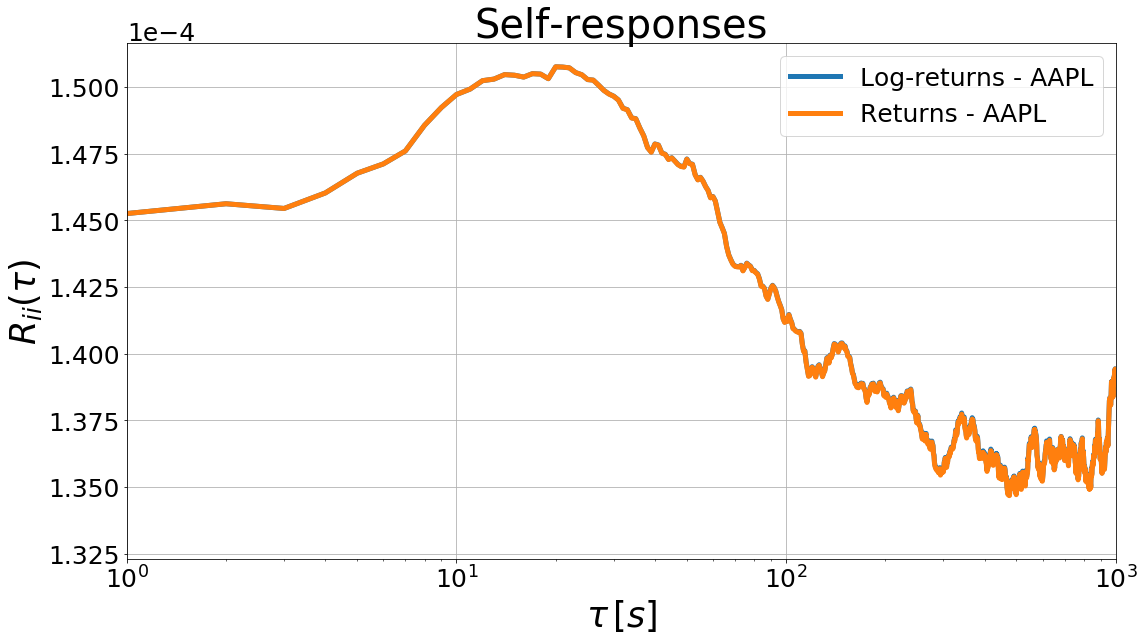

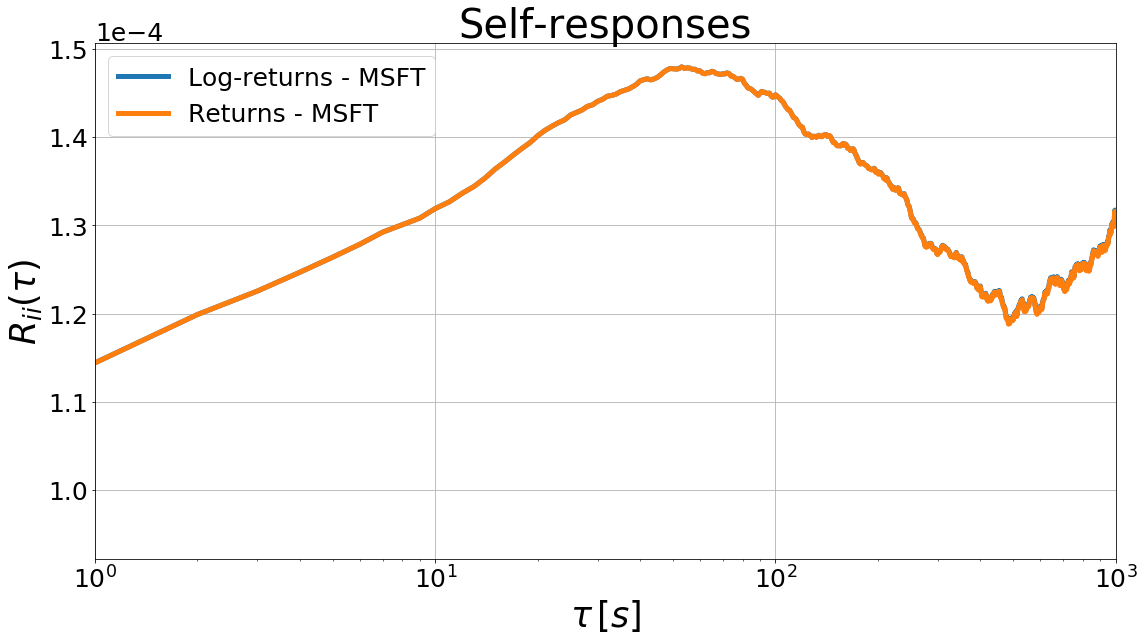

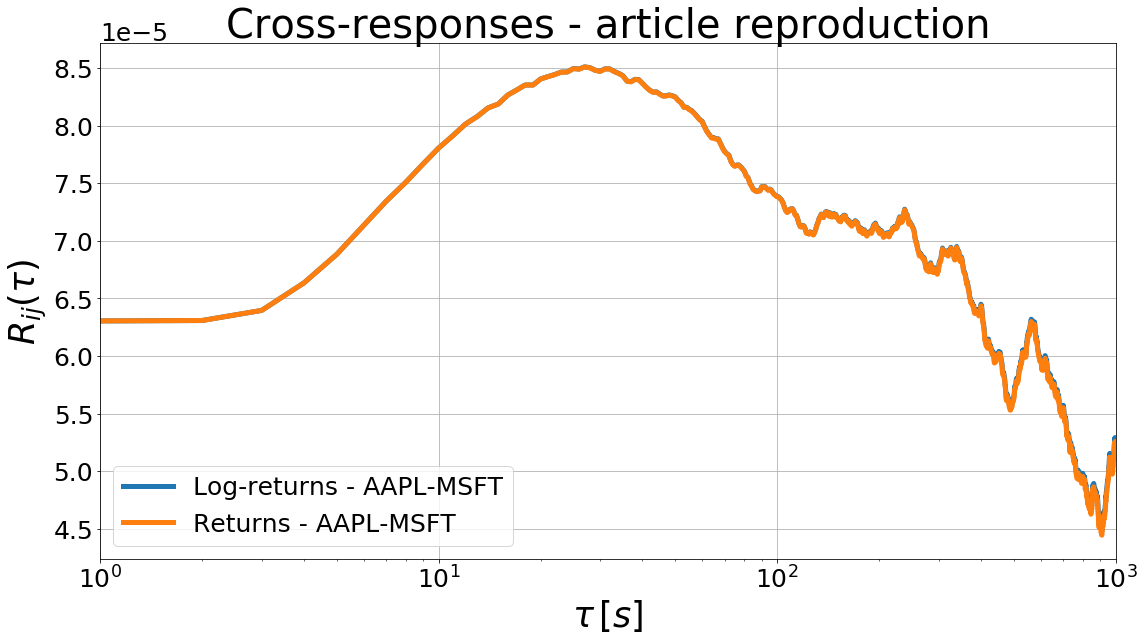

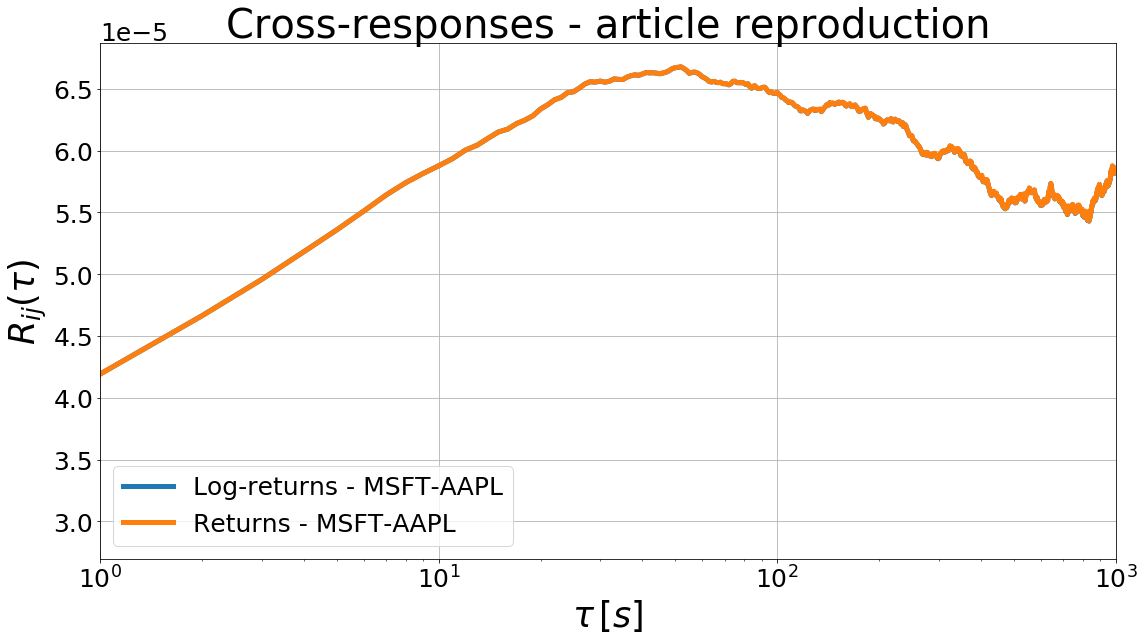

In [9]:
# Run the comparison

tickers = ['AAPL', 'MSFT']
year = '2008'
month = '01'
day = '02'
date = year + '-' + month + '-' + day

for ticker in tickers:
    
    print('++++++++++++++++++++++++++')
    print(f'Results Returns comparison')
    print('++++++++++++++++++++++++++')
    print()
    taq_self_response_returns_comparison(ticker, year)
    
taq_cross_response_returns_comparison(tickers[0], tickers[1], year)
taq_cross_response_returns_comparison(tickers[1], tickers[0], year)